# Path Configuration

In [1]:
import os
import sys
import argparse

root = "../"*3
src_path = os.path.join(root, "kyoka")
sample_path = os.path.join(root, "sample")
sys.path.append(root)
sys.path.append(src_path)
sys.path.append(sample_path)

import logging as log
log.basicConfig(format='[%(levelname)s] %(message)s', level=log.DEBUG)

from kyoka.algorithm.montecarlo.montecarlo import MonteCarlo
from kyoka.algorithm.td_learning.sarsa import Sarsa
from kyoka.algorithm.td_learning.q_learning import QLearning
from kyoka.algorithm.td_learning.sarsa_lambda import SarsaLambda
from kyoka.algorithm.td_learning.q_lambda import QLambda

from kyoka.policy.epsilon_greedy_policy import EpsilonGreedyPolicy
from kyoka.finish_rule.watch_iteration_count import WatchIterationCount

from sample.maze.maze_domain import MazeDomain
from sample.maze.maze_table_value_function import MazeTableValueFunction
from sample.maze.maze_helper import MazeHelper
from sample.maze.maze_performance_logger import MazePerformanceLogger
from sample.maze.maze_transformer import MazeTransformer

# Setup Global Item for Performance Test

In [24]:
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt

maze_file_path = lambda maze_type: "../script/%s.txt" % maze_type
transform_file_path = lambda maze_type: "../script/%s_transformed.txt" % maze_type

def gen_callbacks(maze_type, transform_timing):
    callbacks = [MazePerformanceLogger()]
    if maze_type in ["blocking", "shortcut"]:
        transfomer = MazeTransformer()
        transfomer.set_transformation(transform_timing, transform_file_path(maze_type))
        callbacks.append(transfomer)
    return callbacks

def run_performance_test(maze_type, rl_algo, epsilon, test_length, transform_timing):
    watch_iteration = WatchIterationCount(target_count=test_length, log_interval=1000)
    finish_rules = [watch_iteration]
    domain = MazeDomain()
    domain.read_maze(maze_file_path(maze_type))
    value_func = MazeTableValueFunction(domain.get_maze_shape())
    value_func.setUp()
    policy = EpsilonGreedyPolicy(domain, value_func, eps=epsilon)
    callbacks = gen_callbacks(maze_type, transform_timing)
    [rl_algo.set_gpi_callback(callback) for callback in callbacks]
    rl_algo.GPI(domain, policy, value_func, finish_rules)
    return callbacks[0].step_log, callbacks[0].policy_log

def visualize_maze(maze_type, transform_timing):
    domain = MazeDomain()
    domain.read_maze(maze_file_path(maze_type))
    print "maze shape ( height=%d, width=%d )" % domain.get_maze_shape()
    print
    print "Initial maze shape is ..."
    print
    print MazeHelper.visualize_maze(domain.maze)
    print
    print "After %d iteration, maze transforms into ..." % transform_timing
    print
    domain.read_maze(transform_file_path(maze_type))
    print MazeHelper.visualize_maze(domain.maze)

def visualize_step_transition(step_log):
    print "minimum step => %d" % min(step_log)
    plt.plot(step_log, label="step")
    plt.xlabel("GPI iteration")
    plt.ylabel("step")
    plt.show()
    
def visualize_policy_transition(step_log, policy_log, sampling_interval):
    sampled_log = [(item[0]+1, item[1]) for item in enumerate(policy_log) if (item[0]+1)%sampling_interval==0]
    for iteration, log in sampled_log:
        minimum_step = min(step_log[iteration-sampling_interval:iteration])
        print "After %d th iteration (minimum step => %d)" % (iteration, minimum_step)
        print log
        print

# Blocking Maze

In [21]:
MAZE_TYPE = "blocking"
TEST_LENGTH = 100
TRANSFORM_TIMING = 50
visualize_maze(MAZE_TYPE, TRANSFORM_TIMING)

maze shape ( height=6, width=9 )

Initial maze shape is ...

--------G
---------
---------
XXXXXXXX-
---------
---S-----

After 50 iteration, maze transforms into ...

--------G
---------
---------
-XXXXXXXX
---------
---S-----


## Sarsa

minimum step => 10


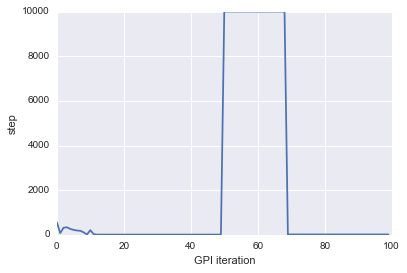

After 10 th iteration (minimum step => 15)
------->G
-------^^
--------^
--------^
----->>>^
------^--

After 20 th iteration (minimum step => 10)
------->G
-------^^
--------^
--------^
----v>>>^
--->>^^--

After 30 th iteration (minimum step => 10)
------->G
-------^^
--------^
--------^
----v>>>^
--->>^^--

After 40 th iteration (minimum step => 10)
------->G
-------^^
--------^
--------^
----v>>>^
--->>^^--

After 50 th iteration (minimum step => 10)
------->G
-------^^
--------^
--------^
----v>>>^
-->>>^^--

After 60 th iteration (minimum step => 10000)
^>vvvv<>G
<<vv>>>^^
>>>>>^<>^
>-------^
>^v>v>>v^
v<>^vv>>^

After 70 th iteration (minimum step => 16)
^>vvvv<>G
<<vv>>>^^
>>>>>^<>^
^-------^
^<<<^<>v>
^<v^>>^>v

After 80 th iteration (minimum step => 16)
^>vvvv<>G
<<vv>>>^^
>>>>>^<>^
^-------^
^<<<^<>v>
^<v^>>^>v

After 90 th iteration (minimum step => 16)
^>vvvv<>G
<<vv>>>^^
>>>>>^<>^
^-------^
^<<<<>v>^
^<^^<<>^^

After 100 th iteration (minimum step => 16)
^>vvvv<>G
<<vv>>>

In [25]:
EPSILON = 0.1
step_log, policy_log = run_performance_test(
    maze_type=MAZE_TYPE, rl_algo=Sarsa(alpha=0.1, gamma=0.7),
    epsilon=EPSILON, test_length=TEST_LENGTH, transform_timing=TRANSFORM_TIMING)
visualize_step_transition(step_log)
visualize_policy_transition(step_log, policy_log, sampling_interval=10)

minimum step => 10


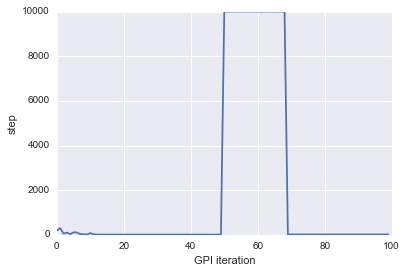

After 10 th iteration (minimum step => 14)
--------G
------->^
--------^
--------^
----->>>^
------^^^

After 20 th iteration (minimum step => 10)
------->G
------->^
-------^^
--------^
---->>>>^
--->>>>^^

After 30 th iteration (minimum step => 10)
------->G
------->^
-------^^
--------^
--->>>>>^
-->>>>>^^

After 40 th iteration (minimum step => 10)
------->G
------->^
-------^^
--------^
--->>>>>^
-->>>>>^^

After 50 th iteration (minimum step => 10)
------->G
------->^
-------^^
--------^
--->>>>>^
-->>>>>^^

After 60 th iteration (minimum step => 10000)
^^vv<>>>G
^v>v<<^>^
<v>>>>>^^
v-------^
>>v>^<^><
<<<>>><^>

After 70 th iteration (minimum step => 16)
^v<v<>>>G
^>>vv<v>^
>>>>>>>^^
^-------^
^<<<<>><^
^^>^<^>>v

After 80 th iteration (minimum step => 16)
^v<v<>>>G
>>>vv<v>^
>>>>>>>^^
^-------^
^<<<<>><^
>^>^<^>>v

After 90 th iteration (minimum step => 16)
^v<v<>>>G
>>>vv<^>^
>>>>>>>^^
^-------^
^<<<<>><^
>^<^<^>>v

After 100 th iteration (minimum step => 16)
^v<v<>>>G
>>>vv<^

In [28]:
EPSILON = 0.3
step_log, policy_log = run_performance_test(
    maze_type=MAZE_TYPE, rl_algo=Sarsa(alpha=0.1, gamma=0.7),
    epsilon=EPSILON, test_length=TEST_LENGTH, transform_timing=TRANSFORM_TIMING)
visualize_step_transition(step_log)
visualize_policy_transition(step_log, policy_log, sampling_interval=10)

minimum step => 10


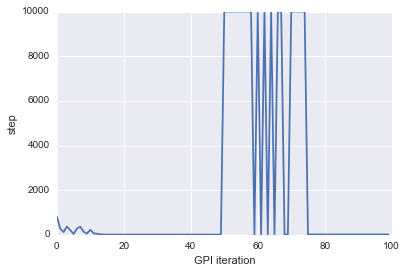

After 10 th iteration (minimum step => 37)
------->G
------>>^
------->^
--------^
--------^
---------

After 20 th iteration (minimum step => 10)
------>>G
------>>^
------->^
--------^
-->vvv>>^
--->>>>^^

After 30 th iteration (minimum step => 10)
------>>G
------>>^
------>>^
--------^
->>>>>>>^
-->>>>>^^

After 40 th iteration (minimum step => 10)
------>>G
------>>^
------>^^
--------^
->>v>>>>^
-->>>>>^^

After 50 th iteration (minimum step => 10)
----->>>G
------>>^
------>^^
--------^
>>v>>>>>^
->>>>>>^^

After 60 th iteration (minimum step => 16)
vv<>>>>>G
v>v>>>>>^
>>>>>>>>^
^-------^
^^<>>>v>^
^<<<>v^^<

After 70 th iteration (minimum step => 16)
>v<>>>>>G
vvv>>>>>^
>>>>>>>>^
^-------^
^<<<^>><>
^^<^><<>^

After 80 th iteration (minimum step => 16)
vv<>>>>>G
v>v>>>>>^
>>>>>>>>^
^-------^
^<<<v^vv^
^<^<>^<>>

After 90 th iteration (minimum step => 16)
vvv>>>>>G
v>v>>>>>^
>>>>>>>>^
^-------^
^<<<<^v>>
^<<<>>>>^

After 100 th iteration (minimum step => 16)
vvv>>>>>G
v>v>>>>>^


In [29]:
EPSILON = 0.7
step_log, policy_log = run_performance_test(
    maze_type=MAZE_TYPE, rl_algo=Sarsa(alpha=0.1, gamma=0.7),
    epsilon=EPSILON, test_length=TEST_LENGTH, transform_timing=TRANSFORM_TIMING)
visualize_step_transition(step_log)
visualize_policy_transition(step_log, policy_log, sampling_interval=10)

# QLearning

minimum step => 10


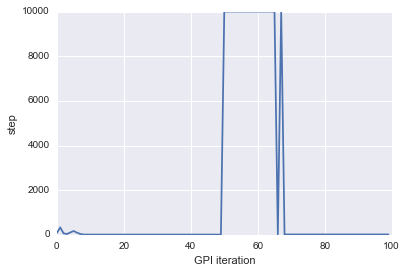

After 10 th iteration (minimum step => 10)
--------G
--------^
--------^
--------^
----->>>^
--->>^---

After 20 th iteration (minimum step => 10)
--------G
--------^
--------^
--------^
---->>>>^
--->>^->^

After 30 th iteration (minimum step => 10)
--------G
--------^
--------^
--------^
---->>>>^
--->>^->^

After 40 th iteration (minimum step => 10)
--------G
--------^
--------^
--------^
--->>>>>^
--->>^->^

After 50 th iteration (minimum step => 10)
--------G
------->^
--------^
--------^
--->>>>>^
--->>^>>^

After 60 th iteration (minimum step => 10000)
<>vvv->vG
v>>>>>>>^
^^^>^<--^
>-------^
v^>v>v^v<
v^><>^>>^

After 70 th iteration (minimum step => 16)
<>vvv->vG
v>>>>>>>^
>^^>^<->^
^-------^
^<<<<<>v^
^^<^vv>>^

After 80 th iteration (minimum step => 16)
<>vvv->vG
v>>>>>>>^
>^^>^<->^
^-------^
^<<<<<>v^
^^<^vv>>^

After 90 th iteration (minimum step => 16)
<>vvv->vG
v>>>>>>>^
>^^>^<^>^
^-------^
^<<<<<>v^
^^<^<v>>^

After 100 th iteration (minimum step => 16)
<>vvv<>vG
v>>>>>>

In [30]:
EPSILON = 0.1
step_log, policy_log = run_performance_test(
    maze_type=MAZE_TYPE, rl_algo=QLearning(alpha=0.1, gamma=0.7),
    epsilon=EPSILON, test_length=TEST_LENGTH, transform_timing=TRANSFORM_TIMING)
visualize_step_transition(step_log)
visualize_policy_transition(step_log, policy_log, sampling_interval=10)

minimum step => 10


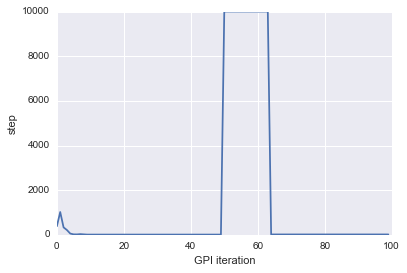

After 10 th iteration (minimum step => 10)
--------G
-------v^
------->^
--------^
---->>>>^
--->^-^>^

After 20 th iteration (minimum step => 10)
--------G
-------v^
------->^
--------^
---v>>>>^
-->>^<^>^

After 30 th iteration (minimum step => 10)
--------G
-------v^
------>>^
--------^
-->v>>>>^
-->>^^^>^

After 40 th iteration (minimum step => 10)
--------G
-------v^
------>>^
--------^
-->v>>>>^
->>>^^^>^

After 50 th iteration (minimum step => 10)
--------G
-------v^
------>>^
--------^
-->v>>>>^
->>>^^^^^

After 60 th iteration (minimum step => 10000)
vv<-----G
>>v<v<v>^
>>>>>>>>^
^-------^
^^v>^vv><
>^v><<>^^

After 70 th iteration (minimum step => 16)
vv<-----G
>>v<v<v>^
>>>>>>>>^
^-------^
^<<<v>><<
>^^<^>^^>

After 80 th iteration (minimum step => 16)
vv<-----G
>>v<v<v>^
>>>>>>>>^
^-------^
^<<<>><><
>^^<<v>^>

After 90 th iteration (minimum step => 16)
vv<-----G
>>v<v<v>^
>>>>>>>>^
^-------^
^<<<>><><
>^^<<v>^>

After 100 th iteration (minimum step => 16)
vv<-----G
>>vvv<v

In [31]:
EPSILON = 0.3
step_log, policy_log = run_performance_test(
    maze_type=MAZE_TYPE, rl_algo=QLearning(alpha=0.1, gamma=0.7),
    epsilon=EPSILON, test_length=TEST_LENGTH, transform_timing=TRANSFORM_TIMING)
visualize_step_transition(step_log)
visualize_policy_transition(step_log, policy_log, sampling_interval=10)

minimum step => 10


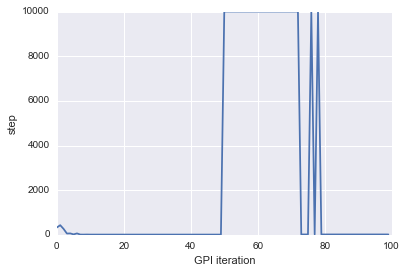

After 10 th iteration (minimum step => 10)
------->G
------>>^
------->^
--------^
--->>>>>^
-----^>^^

After 20 th iteration (minimum step => 10)
------->G
------>>^
------->^
--------^
>>>>>>>>^
-^^^>^>^^

After 30 th iteration (minimum step => 10)
------->G
------>>^
------->^
--------^
>>>>>>>>^
-^>^^^>^^

After 40 th iteration (minimum step => 10)
------>>G
----->>>^
------>>^
--------^
>>>>>>>>^
>^>^^^^^^

After 50 th iteration (minimum step => 10)
----v>>>G
---->>>>^
-----^>>^
--------^
>>>>>>>>^
>^>^^^^^^

After 60 th iteration (minimum step => 10000)
v<>>v>>>G
vv<>>>>>^
>>>>>>>>^
^-------^
^^>^^v>^v
>>><^<>^v

After 70 th iteration (minimum step => 10000)
v<v>v>>>G
vv>>>>>>^
>>>>>>>>^
^-------^
^<^>v>>^<
^v<^vv<>^

After 80 th iteration (minimum step => 16)
v<vvv>>>G
v>>>>>>>^
>>>>>>>>^
^-------^
^<<v>>>>^
^^<<>v<>v

After 90 th iteration (minimum step => 16)
vvvvv>>>G
v>>>>>>>^
>>>>>>>>^
^-------^
^<<<^^>>^
^^<<>^<<>

After 100 th iteration (minimum step => 16)
vvvvv>>>G
>>>>

In [32]:
EPSILON = 0.7
step_log, policy_log = run_performance_test(
    maze_type=MAZE_TYPE, rl_algo=QLearning(alpha=0.1, gamma=0.7),
    epsilon=EPSILON, test_length=TEST_LENGTH, transform_timing=TRANSFORM_TIMING)
visualize_step_transition(step_log)
visualize_policy_transition(step_log, policy_log, sampling_interval=10)

# SarsaLambda

minimum step => 10


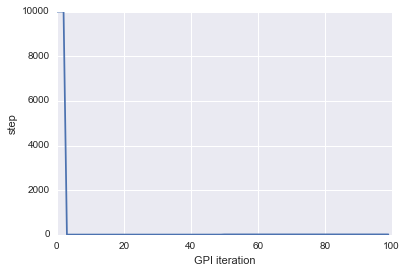

After 10 th iteration (minimum step => 10)
---v<>>>G
--->>^^^^
---^^-->^
--------^
><v^-->>^
<<>>>>>^>

After 20 th iteration (minimum step => 10)
---v<>>>G
--->>^^^^
---^^-->^
--------^
><v^v->>^
<<>>>>>^>

After 30 th iteration (minimum step => 10)
---v<>>>G
--->>^^^^
---^^-->^
--------^
><v^v^>>^
<<>>>>>^>

After 40 th iteration (minimum step => 10)
---v<>>>G
--->>^^^^
---^^-->^
--------^
><v^v^>>^
<<>>>>>^>

After 50 th iteration (minimum step => 10)
---v<>>>G
--->>^^^^
---^^-->^
--------^
><v^v^>>^
<<>>>>>^v

After 60 th iteration (minimum step => 18)
---v<>>>G
>>v>>^^^^
^^>^^-->^
^-------^
^<v^<<<v<
<^<<>v^<>

After 70 th iteration (minimum step => 18)
---v<>>>G
>>v>>^^^^
^^>^^-->^
^-------^
^<v^<<<v<
<^<<>v^<>

After 80 th iteration (minimum step => 18)
---v<>>>G
>>v>>^^^^
^^>^^-->^
^-------^
^<v^<<<v<
<^<<>v^<>

After 90 th iteration (minimum step => 18)
---v<>>>G
>>v>>^^^^
^^>^^-->^
^-------^
^<v^<<<v<
<^<<>v^<>

After 100 th iteration (minimum step => 18)
v--v<>>>G
>>v>>^^^^


In [33]:
EPSILON = 0.1
step_log, policy_log = run_performance_test(
    maze_type=MAZE_TYPE, rl_algo=SarsaLambda(alpha=0.1, gamma=0.9),
    epsilon=EPSILON, test_length=TEST_LENGTH, transform_timing=TRANSFORM_TIMING)
visualize_step_transition(step_log)
visualize_policy_transition(step_log, policy_log, sampling_interval=10)

minimum step => 10


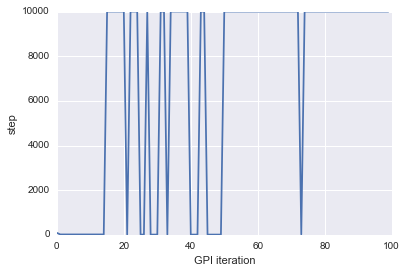

After 10 th iteration (minimum step => 16)
<^v<v>>vG
>>>vv^^>^
^>>>>^^<<
--------^
>^v<v^^>^
v>>>>>>^<

After 20 th iteration (minimum step => 16)
<^v<v>>vG
>>>vv^^>^
^>>>>^^<^
--------^
<><^v^^>^
v^^v>>>^<

After 30 th iteration (minimum step => 10)
<^v<v>>vG
>>>vv^^>^
^>>>>^^<^
--------^
<>v^vv>>^
v^^>>>>^<

After 40 th iteration (minimum step => 10)
<^v<v>>vG
>>>vv^^>^
^>>>>^^<^
--------^
^<^>vv>>^
v^>v>>>^<

After 50 th iteration (minimum step => 10)
<^v<v>>vG
>>>vv^^>^
^>>>>^^<^
--------^
^<^>vv>>^
v^>>>>>^<

After 60 th iteration (minimum step => 10000)
v<v<^>>>G
v^<v>>^>^
><>>^>^<^
v-------^
^v<>v><<<
>^<<^^<^<

After 70 th iteration (minimum step => 10000)
v^<<^>>>G
<^<v>>^>^
>>>>^>^<^
^-------^
^<^<<v<<>
>>vv>^<^^

After 80 th iteration (minimum step => 20)
v^<<^>>>G
<v<v>>^>^
<>>>^>^<^
v-------^
>v>v>^>v^
<<<><<^>>

After 90 th iteration (minimum step => 10000)
^><<^>>>G
>v<v>>^>^
^>>>^>^<^
^-------^
>>>>v><<v
^v<^v^vv<

After 100 th iteration (minimum step => 10000)
>><<^>>>

In [34]:
EPSILON = 0.3
step_log, policy_log = run_performance_test(
    maze_type=MAZE_TYPE, rl_algo=SarsaLambda(alpha=0.1, gamma=0.7),
    epsilon=EPSILON, test_length=TEST_LENGTH, transform_timing=TRANSFORM_TIMING)
visualize_step_transition(step_log)
visualize_policy_transition(step_log, policy_log, sampling_interval=10)

minimum step => 12


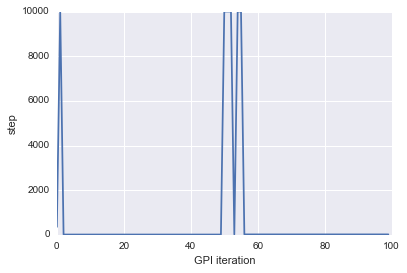

After 10 th iteration (minimum step => 12)
vvvv<<<>G
>>>vvv>^<
>^<^>>^<^
--------^
--->>>>>^
--->^^<v^

After 20 th iteration (minimum step => 12)
vvvvv<<>G
>>>vvv>^<
>^<^>>^<^
--------^
-->>>>>>^
--^>^^^v^

After 30 th iteration (minimum step => 12)
vvvvv<>>G
>>>vvv>^<
>^<^>>^<^
--------^
-->>>>>>^
--^>^^^v^

After 40 th iteration (minimum step => 12)
vvvvv<>>G
>>>vvv>^<
>^<^>>^<^
--------^
-->>>>>>^
--^>^^^v^

After 50 th iteration (minimum step => 12)
vvvvv<>>G
>>>vvv>^<
>^<^>>^<^
--------^
-->>>>>>^
--^>^^^v^

After 60 th iteration (minimum step => 18)
vvvvv<>>G
>>>>vv>^<
>^^^>>^<^
^-------^
^<<<<v<<<
>>^<v<<^<

After 70 th iteration (minimum step => 18)
vvvvv<>>G
>>>>vv>^<
>^^^>>^<^
^-------^
^<<<<v<<<
>>^<v<<^<

After 80 th iteration (minimum step => 18)
vvvvvv>>G
>>>>vv>^<
>^^^>>^<^
^-------^
^<<<<v<<<
>>^<v<<^<

After 90 th iteration (minimum step => 18)
vvvvvv>>G
>>>>vv>^<
>^^^>>^<^
^-------^
^<<<<v<<<
>>^<v<<^<

After 100 th iteration (minimum step => 18)
vvvvvv>>G
>>>>vv>^<


In [35]:
EPSILON = 0.3
step_log, policy_log = run_performance_test(
    maze_type=MAZE_TYPE, rl_algo=SarsaLambda(alpha=0.1, gamma=0.9),
    epsilon=EPSILON, test_length=TEST_LENGTH, transform_timing=TRANSFORM_TIMING)
visualize_step_transition(step_log)
visualize_policy_transition(step_log, policy_log, sampling_interval=10)

minimum step => 10


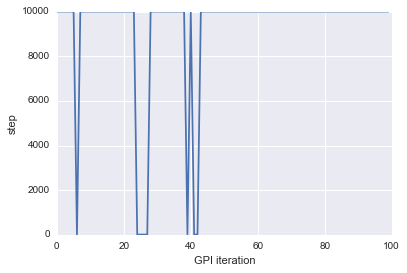

After 10 th iteration (minimum step => 10)
-->>^>^>G
--^^<>>^^
------^v^
--------^
^v^><>>>^
>>>v^v^>v

After 20 th iteration (minimum step => 10000)
-->>>>>>G
--^^v<>^^
---^<v^v^
--------^
^<^>>^^<^
v<v^<>v>v

After 30 th iteration (minimum step => 10)
-->>>>>>G
--^^v<>^^
---^<v^v^
--------^
^><>><><^
^vvv><>>^

After 40 th iteration (minimum step => 10)
-->>>>>>G
--^^v<>^^
---^<v^^^
--------^
>^v>>>>>^
v<^>^<^<<

After 50 th iteration (minimum step => 10)
-->>>>>>G
--^^v^^^^
---^^-^^^
--------^
>>^vvv>>^
><^><^^<v

After 60 th iteration (minimum step => 10000)
v^>>>>>>G
v><^>>^^^
>>>>>^^^^
^-------^
^v>vvv>>>
^^<<<^^<v

After 70 th iteration (minimum step => 10000)
<vvv>>>>G
<>>>^>^^^
>>^v>^^^^
^-------^
<<<vvv<>>
^^v<<<<<v

After 80 th iteration (minimum step => 10000)
v><v>>>>G
>>v>^v>^^
^v^^>>^^^
<-------^
>v>v<<vvv
>^<^<^vv<

After 90 th iteration (minimum step => 10000)
<^<v>>>>G
<<<>>^>^^
<<^v>>>^^
v-------^
vv<>v<<vv
^<<<<^vv^

After 100 th iteration (minimum step => 10000)
<>

In [36]:
EPSILON = 0.7
step_log, policy_log = run_performance_test(
    maze_type=MAZE_TYPE, rl_algo=SarsaLambda(alpha=0.1, gamma=0.7),
    epsilon=EPSILON, test_length=TEST_LENGTH, transform_timing=TRANSFORM_TIMING)
visualize_step_transition(step_log)
visualize_policy_transition(step_log, policy_log, sampling_interval=10)

# QLambda

minimum step => 14


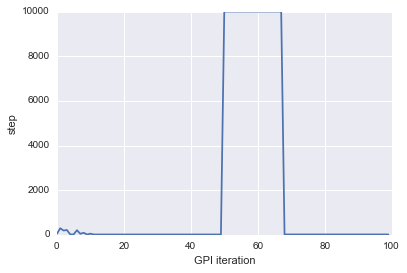

After 10 th iteration (minimum step => 15)
------->G
------>^<
------^-^
--------^
----->>v^
-----^->^

After 20 th iteration (minimum step => 14)
------->G
------>^<
------^-^
--------^
---->>>v^
--->^^<>^

After 30 th iteration (minimum step => 14)
------->G
------>^<
------^<^
--------^
---->>>v^
-->>^^<>^

After 40 th iteration (minimum step => 14)
------->G
------>^<
------^<^
--------^
---->>>v^
-->>^^<>^

After 50 th iteration (minimum step => 14)
------->G
------>^<
------^<^
--------^
--->>>>v^
-->>^^<>^

After 60 th iteration (minimum step => 10000)
--vvv-->G
->>>>>>^<
--->^^^<^
--------^
--->v>>>v
-->v>vv--

After 70 th iteration (minimum step => 16)
--vvv-v>G
>>>>>>>^<
^^->^^^<^
^-------^
^<<>>>>>v
--^<<<v--

After 80 th iteration (minimum step => 16)
->vvv-v>G
>>>>>>>^<
^^^>^^^<^
^-------^
^<<>>>>>v
-^^<<<v--

After 90 th iteration (minimum step => 16)
->vvv-v>G
>>>>>>>^<
^^^>^^^<^
^-------^
^<<>>>>>v
-^^<<<v--

After 100 th iteration (minimum step => 16)
->vvv-v>G
>>>>>>>

In [37]:
EPSILON = 0.1
step_log, policy_log = run_performance_test(
    maze_type=MAZE_TYPE, rl_algo=QLambda(alpha=0.1, gamma=0.7),
    epsilon=EPSILON, test_length=TEST_LENGTH, transform_timing=TRANSFORM_TIMING)
visualize_step_transition(step_log)
visualize_policy_transition(step_log, policy_log, sampling_interval=10)

minimum step => 10


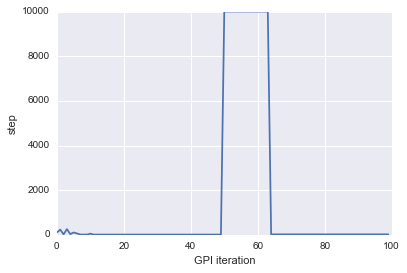

After 10 th iteration (minimum step => 10)
------->G
--------^
--------^
--------^
---->>>>^
---->^-^<

After 20 th iteration (minimum step => 10)
------->G
-------^^
------->^
--------^
->>>>>>>^
-^<^>^<^<

After 30 th iteration (minimum step => 10)
------->G
-------^^
------>>^
--------^
->>>>>>>^
-^^^>^<^<

After 40 th iteration (minimum step => 10)
------->G
-------^^
------>>^
--------^
->>>>>>>^
-^^^>^<^<

After 50 th iteration (minimum step => 10)
------->G
-------^^
------>>^
--------^
->>>>>>>^
-^^^>^<^<

After 60 th iteration (minimum step => 10000)
>>>vv<->G
>>^>>vv^^
^^-^>>>>^
--------^
->>>^<<^v
-^^^^<<^<

After 70 th iteration (minimum step => 20)
>>>vv<v>G
>>^>>v>^^
^^^^>>>>^
^-------^
^<>>v><^v
^^<<<<>^<

After 80 th iteration (minimum step => 20)
>>>vv<v>G
>>^>>v>^^
^^^^>>>>^
^-------^
^<<>v><^v
^^<<<<>^<

After 90 th iteration (minimum step => 20)
>>>vv<v>G
>>^>>v>^^
^^^^>>>>^
^-------^
^<<>v><^v
^^<<<<>^<

After 100 th iteration (minimum step => 20)
>>>vvvv>G
>>^>>v>

In [38]:
EPSILON = 0.3
step_log, policy_log = run_performance_test(
    maze_type=MAZE_TYPE, rl_algo=QLambda(alpha=0.1, gamma=0.7),
    epsilon=EPSILON, test_length=TEST_LENGTH, transform_timing=TRANSFORM_TIMING)
visualize_step_transition(step_log)
visualize_policy_transition(step_log, policy_log, sampling_interval=10)

minimum step => 10


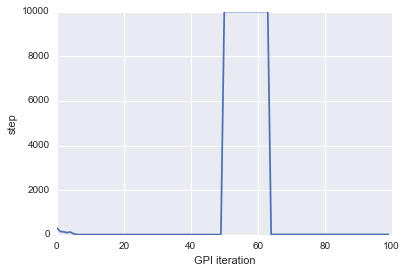

After 10 th iteration (minimum step => 10)
--------G
-----v->^
---->>>>^
--------^
-v>>>>>>^
>>>>^^>>^

After 20 th iteration (minimum step => 10)
-----vv>G
-->v>v>>^
-->>>>>>^
--------^
>v>>>>>>^
>>>>^^<^^

After 30 th iteration (minimum step => 10)
---vvv>>G
->>v>v>>^
-^>>>>>>^
--------^
v>>>>>>>^
>>>>^^<^^

After 40 th iteration (minimum step => 10)
---vvv>>G
->>v>>v>^
-^>>>>>>^
--------^
v>>>>>>>^
>>>>^^^^^

After 50 th iteration (minimum step => 10)
---v>v>>G
->>v>>v>^
-^>>>>>>^
--------^
v>>>>>>>^
>>>>^^^^^

After 60 th iteration (minimum step => 10000)
>vvv>>>>G
>>vv>>v>^
>^>>>>>>^
^-------^
^v>>v>^vv
v^^^^vv>^

After 70 th iteration (minimum step => 16)
>vv>v>>>G
>>vv>>>>^
>>>>>>>>^
^-------^
^<<<<>><<
^<^<>>>v<

After 80 th iteration (minimum step => 16)
>vv>v>>>G
>>v>>>>>^
>>>>>>>>^
^-------^
^<<<<<<<^
^<^^^^<v^

After 90 th iteration (minimum step => 16)
>vv>v>>>G
>>v>>>>>^
>>>>>>>>^
^-------^
^<<<<<<<^
^<^<^^<v^

After 100 th iteration (minimum step => 16)
>vvvv>>>G
>>>>>>>

In [39]:
EPSILON = 0.7
step_log, policy_log = run_performance_test(
    maze_type=MAZE_TYPE, rl_algo=QLambda(alpha=0.1, gamma=0.7),
    epsilon=EPSILON, test_length=TEST_LENGTH, transform_timing=TRANSFORM_TIMING)
visualize_step_transition(step_log)
visualize_policy_transition(step_log, policy_log, sampling_interval=10)